## Global Import

In [ ]:
import os, gc, warnings, random, math
import datetime
from datetime import timedelta
from joblib import Parallel, delayed
import multiprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import copy
import pickle
import json

from time import sleep
from tqdm.contrib import tzip

warnings.filterwarnings('ignore')

import tensorflow as tf

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier, XGBRegressor

import torch
from torch.optim import Rprop

from random import seed

from tensorflow.keras import backend as K
from tensorflow.keras import initializers

from math import floor
from itertools import chain

import pandas as pd
import numpy as np
import operator
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler #менее подвержан выбросам
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
!pip install imblearn
from imblearn.over_sampling import SMOTE
import itertools
from collections import Counter
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,\
roc_auc_score,roc_curve,matthews_corrcoef,recall_score,precision_score,classification_report,f1_score,cohen_kappa_score, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Настройки визуализации
%matplotlib inline
plt.style.use('ggplot')
sns.set(style='whitegrid')
sns.set_context('talk')

## Основные параметры модуля

In [ ]:
DATA_PATH = '../data/'
PNG_PATH = '../png/'
PREPROCESSED_DATA_PATH = '../preprocessed data/'
SYNTHETIC_DATA_PATH = '../synthetic data/'

## Генерация данных с помощью DataSynthesizer для карт из кластера 3
DataSynthesizer Usage (correlated attribute mode)

### Step 1 import packages

In [ ]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

###Step 1.2 Input data building

In [ ]:
df_svista = pd.read_csv(f'{PREPROCESSED_DATA_PATH}prep_data.csv')
df_clusters = pd.read_csv(f'{PREPROCESSED_DATA_PATH}data_clusters.csv')

In [ ]:
print('Кол-во признаков:', len(df_svista.columns))
print(list(df_svista.columns))
print(df_svista.info())
for column in df_svista.columns:
  print(eval("83*'_'"),'\n',"Column: ", column,"  Num of unique: ", len(df_svista[column].unique()), '\n', "Unique data:", df_svista[column].unique()[:5], sep='')

In [ ]:
df_clusters.groupby('labels_PCA').count()

In [ ]:
df_svista_cl = df_svista.merge(df_clusters, on=["CARDID_NUM"])
df_input = df_svista_cl[df_svista_cl['labels_PCA']==3].copy(deep=True)
df_input.drop(columns='labels_PCA', inplace=True)

In [ ]:
print('Кол-во признаков:', len(df_input.columns))
print(list(df_input.columns))
print(df_input.info())
for column in df_input.columns:
  print(eval("83*'_'"),'\n',"Column: ", column,"  Num of unique: ", len(df_input[column].unique()), '\n', "Unique data:", df_input[column].unique()[:5], sep='')

### Step 2 user-defined parameteres

In [ ]:
# STATIC PARAMETERES

# An attribute is categorical if its domain size is less than this threshold.
# Here modify the threshold to adapt to the domain size of "education" (which is 14 in input dataset).
threshold_value = 30

# specify categorical attributes
categorical_attributes = {'MCC_freq': True,
                          'TERMINAL_ID_freq':True,
                          'AUTH_RESP_CODE_freq': True,
                          'PDC_CARDHOLDER_PRES_freq': True,
                          'MERCH_COUNTRY_freq': True,
                          'MERCH_CITY_freq': True,
                          'MERCH_POSTAL_CODE_freq': True,
                          'MERCH_ID_freq': True,
                          'CVV2_PRES_freq': True,
                          'TRANS_TYPE_freq': True,
                          'PDC_CARD_CAPTURE_CAP_freq': True,
                          'PDC_CARD_PRES_freq': True,
                          'PIN_PRES_freq': True,
                          'DATE_TIME_SEC': False                          
                          }

# specify which attributes are candidate keys of input dataset.
candidate_keys = {'CARDID_NUM': True,
                  'DATE_TIME_SEC': False}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 0

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 3

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = 400 

### Step 2 + 3 + 4 DYNAMIC PARAMETERES/DataDescriber/generate synthetic dataset

1. Set dynamic parameters
________________________________________________________________________________

1. Instantiate a DataDescriber.
2. Compute the statistics of the dataset.
3. Save dataset description to a file on local machine.
________________________________________________________________________________

1. Instantiate a DataGenerator.
2. Generate a synthetic dataset.
3. Save it to local machine.

In [ ]:
for i in tqdm(df_input['CARDID_NUM'].unique()):

  # DYNAMIC PARAMETERES

  # input dataset
  df_thecard = df_input[df_input['CARDID_NUM']==i].copy(deep=True)
  if not os.path.isfile(f'{PREPROCESSED_DATA_PATH}prep_data_card_{i}.csv'):
    df_thecard.to_csv(f'{PREPROCESSED_DATA_PATH}prep_data_card_{i}.csv', index=False)
  input_data = f'{PREPROCESSED_DATA_PATH}prep_data_card_{i}.csv'
  # location of two output files
  description_file = f'{SYNTHETIC_DATA_PATH}description_card_{i}.json'
  synthetic_data = f'{SYNTHETIC_DATA_PATH}sythetic_data_DS_card_{i}.csv'

  # DESCTIBE DATA

  print('#'*70,f' CARD {i} ','#'*70)
  describer = DataDescriber(category_threshold=threshold_value)
  describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                          epsilon=epsilon, 
                                                          k=degree_of_bayesian_network,
                                                          attribute_to_is_categorical=categorical_attributes,
                                                          attribute_to_is_candidate_key=candidate_keys,
                                                          seed=123)
  describer.save_dataset_description_to_file(description_file)
  print()
  display_bayesian_network(describer.bayesian_network)

  # GENERATE SYNTHETIC DATA

  generator = DataGenerator()
  generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
  generator.save_synthetic_data(synthetic_data)

### Step 5 compare the statistics of input and sythetic data (optional)

The synthetic data is already saved in a file by step 4. The ModelInspector is for a quick test on the similarity between input and synthetic datasets.

#### 5.1 instantiate a ModelInspector.

It needs input dataset, synthetic dataset, and attribute description.

In [ ]:
# Choose card to visualise
THECARD = 0

# Read both datasets using Pandas.
input_df = pd.read_csv(f'{PREPROCESSED_DATA_PATH}prep_data_card_{THECARD}.csv')
synthetic_data = f'{SYNTHETIC_DATA_PATH}sythetic_data_DS_card_{THECARD}.csv'
description_file = f'{SYNTHETIC_DATA_PATH}description_card_{THECARD}.json'

synthetic_df = pd.read_csv(synthetic_data)

# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']

inspector = ModelInspector(input_df, synthetic_df, attribute_description)

In [ ]:
input_df = pd.read_csv(f'{PREPROCESSED_DATA_PATH}prep_data_card_{THECARD}.csv')
input_df

In [ ]:
synthetic_df

#### 5.2 compare histograms between input and synthetic datasets.

In [ ]:
for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute)

#### 5.3 compare pairwise mutual information

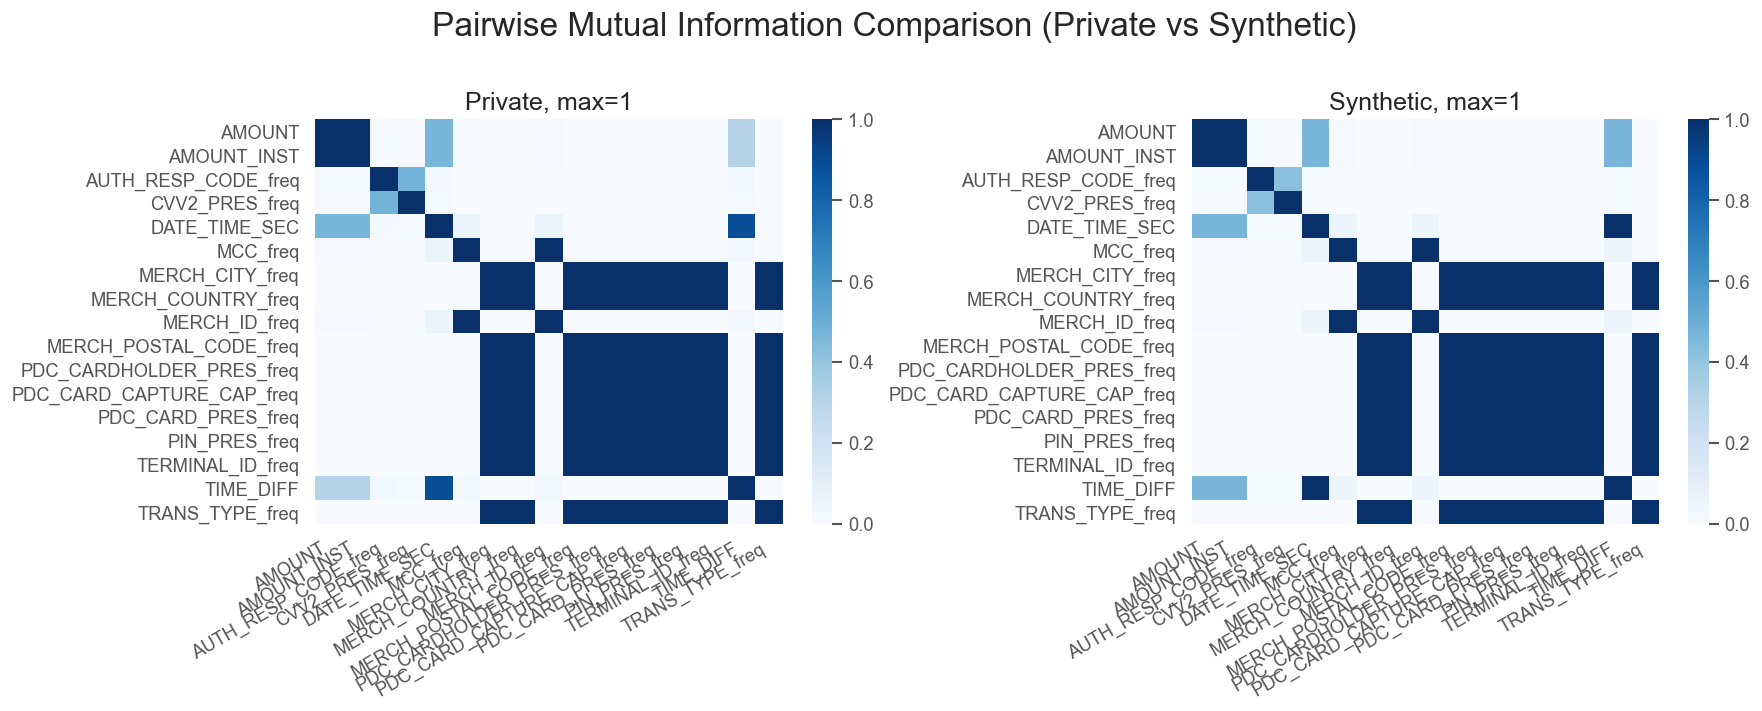

In [ ]:
inspector.mutual_information_heatmap()

#### Step 5.3 Data visualisation

In [ ]:
synthetic_df = synthetic_df.sort_values(['DATE_TIME_SEC'], ascending=[True])
synthetic_df.reset_index(drop=True, inplace=True)

In [ ]:
synthetic_df

,AMOUNT,AMOUNT_INST,DATE_TIME_SEC,TIME_DIFF,MCC_freq,TERMINAL_ID_freq,AUTH_RESP_CODE_freq,PDC_CARDHOLDER_PRES_freq,MERCH_COUNTRY_freq,MERCH_CITY_freq,MERCH_POSTAL_CODE_freq,MERCH_ID_freq,CVV2_PRES_freq,TRANS_TYPE_freq,PDC_CARD_CAPTURE_CAP_freq,PDC_CARD_PRES_freq,PIN_PRES_freq
0,7300,7300,1.503552e+09,41741.133354,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,0.954179,0.93024,0.987578
1,36500,36500,1.506903e+09,101492.413642,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,0.954179,0.93024,0.987578
2,18000,18000,1.506904e+09,157806.111843,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,0.954179,0.93024,0.987578
3,18000,18000,1.506951e+09,7118.404638,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,0.954179,0.93024,0.987578
4,36500,36500,1.506973e+09,151764.869561,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,0.954179,0.93024,0.987578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1800,1800,1.512318e+09,93805.517418,0.073955,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.044587,0.530355,0.66823,0.954179,0.93024,0.987578
396,350,350,1.512319e+09,59464.130222,0.073955,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.044587,0.530355,0.66823,0.954179,0.93024,0.987578
397,7300,7300,1.512321e+09,33521.203097,0.073955,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.044587,0.530355,0.66823,0.954179,0.93024,0.987578
398,36500,36500,1.512324e+09,21149.318595,0.073955,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.044587,0.530355,0.66823,0.954179,0.93024,0.987578


In [ ]:
%config InlineBackend.figure_format = 'svg' #Отображение графиков в формате svg
plt.figure(figsize=(18,10))
plt.plot(synthetic_df['AMOUNT'])
plt.title('Amount plot')
if not os.path.isfile(f'{PNG_PATH}/synthetic_DS_amount_CARD_{THECARD}.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  plt.savefig(f'{PNG_PATH}/synthetic_DS_amount_CARD_{THECARD}', dpi=300)

In [ ]:
%config InlineBackend.figure_format = 'svg' #Отображение графиков в формате svg
plt.figure(figsize=(18,10))
plt.plot(synthetic_df['DATE_TIME_SEC'])
plt.title(f'Time in sec plot card {THECARD}')
#%config InlineBackend.figure_format = 'svg' #Отображение графиков в формате svg
if not os.path.isfile(f'{PNG_PATH}/synthetic_DS_time_plot_CARD_{THECARD}.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  plt.savefig(f'{PNG_PATH}/synthetic_DS_time_plot_CARD_{THECARD}', dpi=300)

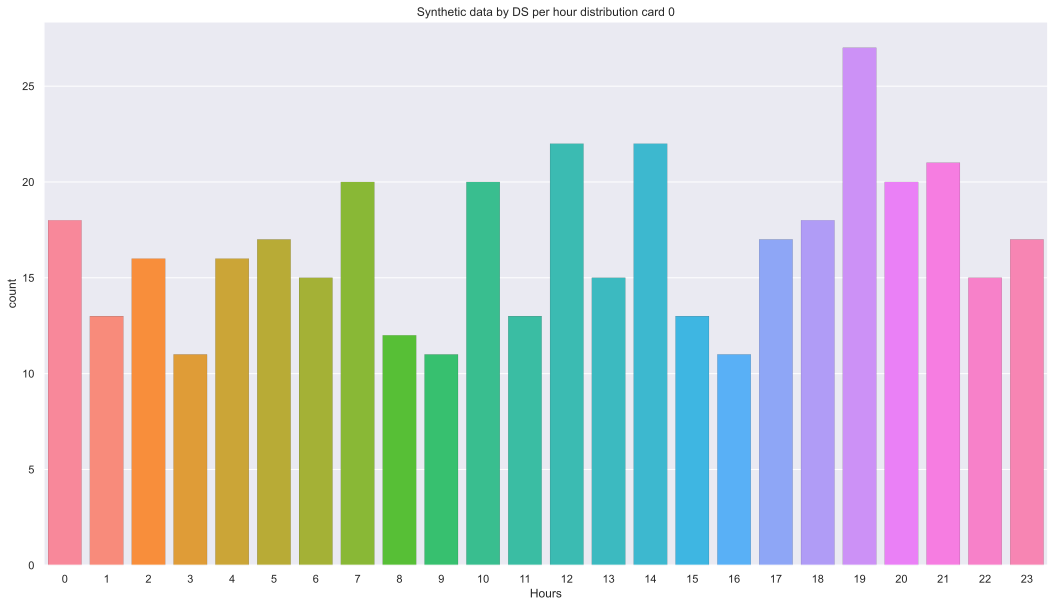

In [ ]:
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(18,10))
sns.set(style="darkgrid")
#plt.title("Count Plot of Transactions per each hour\n", fontsize=16)
#sns.set_context("paper", font_scale=1.4)
df1 = synthetic_df.copy(deep=True)
####################
minutes = df1['DATE_TIME_SEC']/60
minutes = minutes.astype(int)
df1['Minutes']=minutes
hours = ((df1['Minutes']/60)-417384) % 24
hours = hours.astype(int)
df1['Hours'] = hours
####################
sns.countplot(data = df1,
              x = 'Hours',
              edgecolor=(0,0,0),
              linewidth=0.1,
              saturation=1)
plt.title(f'Synthetic data by DS per hour distribution card {THECARD}')
if not os.path.isfile(f'{PNG_PATH}/transactions_per_hour_synthetic_DS_CARD_{THECARD}.png'):
  plt.savefig(f'{PNG_PATH}/transactions_per_hour_synthetic_DS_CARD_{THECARD}', dpi=300)
plt.show()

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.figure(figsize=(60,10))
#plt.figure(figsize=(40,6))
sns.set(style="darkgrid")
#plt.title("Count Plot of Transactions per each hour\n", fontsize=16)
#sns.set_context("paper", font_scale=1.4)
df1 = synthetic_df.copy(deep=True)
DAY = (df1['DATE_TIME_SEC']/86400)
DAY = DAY.astype(int)
DAY = DAY - DAY.min()
df1['DAY']=DAY
sns.countplot(data = df1,
              x = 'DAY',
              edgecolor=(0,0,0),
              linewidth=0.3,
              saturation=1)
if not os.path.isfile(f'{PNG_PATH}/transactions_per_day_synthetic_DS_CARD_{THECARD}'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  plt.savefig(f'{PNG_PATH}/transactions_per_day_synthetic_DS_{THECARD}', dpi=300)
plt.show()

## Генерация данных с помощью имитационного моделирования покупателя

### import packages

In [ ]:
import random as r
import numpy as np
import math
import datetime
import csv

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import sklearn.metrics as m
plt.style.use('ggplot')
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
#%matplotlib

### classes and functions

In [ ]:
SHOPPING_TIME = [7, 10, 13, 16, 19]
PRODUCT_TYPES = ["хлебопекарная продукция", "молочная продукция", "зерновые", "овощи", "фрукты",
                 "кондитерская изделия", "мясная продукция", "средства гигиены", "парикмахерская", "снятие наличных",
                 "кафе", "денежный перевод", "канцтовары", "тренажерный зал", "книги",
                 "кинотеатр", "спорт товары", "обувь", "одежда", "техника"]
PRODUCT_PRICES = {'парикмахерская': 250, 'молочная продукция': 100, 'одежда': 2000, 'обувь': 2000, 'тренажерный зал': 250,
                  'канцтовары': 200, 'снятие наличных': 500, 'денежный перевод': 500, 'мясная продукция': 300, 'техника': 2500,
                  'кафе': 300, 'средства гигиены': 200, 'кондитерская изделия': 250, 'спорт товары': 500, 'зерновые': 100,
                  'овощи': 100, 'фрукты': 150, 'кинотеатр': 200, 'книги': 150, 'хлебопекарная продукция': 70}
NUMBER_OF_CLIENTS = 1000
NUMBER_OF_MERCHANTS = 50
DATE = datetime.date(2020, 1, 1)
DAYS_IN_MONTH_2020 = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]


class Client:
    id = 0
    residence = [0, 0]
    speed = 5                      # m/s
    product_list = {}
    income = 0
    cash = 0
    shopping_time = "16"

    def __init__(self, id):
        self.id = id
        self.residence = [r.randint(0, 6000), r.randint(0, 6000)]
        self.speed = r.randint(10, 20)/10
        self.product_list = gen_product_list()
        self.income = r.randint(15000, 40000)
        self.shopping_time = gen_day_type()

    def month_income(self):
        self.cash += self.income

    def gen_day_needs(self):
        num_of_needs = r.randint(1, 3)
        day_needs = {}
        upper_limit = 6
        priorities = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        for i in range(num_of_needs):
            random_value = r.randint(0, upper_limit)
            day_needs.update({priorities[random_value]: self.product_list[priorities[random_value]]})
            del priorities[random_value]
            if i == 1:
                upper_limit += 1
        return day_needs

    def nearest_merchant(self, c_m_dist, m_m_dist, m_list, need):
        candidates = list()
        for merchant in m_list:
            if merchant.product_type == need:
                candidates.append(merchant.id)
        min_dist_id = candidates[0]
        for m_id in candidates:
            if c_m_dist[self.id][m_id] < c_m_dist[self.id][min_dist_id]:
                min_dist_id = m_id
        return min_dist_id

    def day_shopping(self, dist_c_m, dist_m_m, list_m, date):
        transactions = list()
        needs = dict(self.gen_day_needs())
        list_keys = list(needs.keys())
        list_keys.sort()
        m_id = 0
        seconds = 0
        if self.cash >= PRODUCT_PRICES[needs[list_keys[0]]]:
            m_id = self.nearest_merchant(dist_c_m, dist_m_m, list_m, needs[list_keys[0]])
            dist = dist_c_m[self.id][m_id]
            seconds = dist / self.speed + 300
            self.cash -= PRODUCT_PRICES[needs[list_keys[0]]]
            transactions.append(Transaction(self.id, m_id, date, datetime.time(self.shopping_time+int(seconds//3600), int((seconds%3600)//60), int(seconds%60)), PRODUCT_PRICES[needs[list_keys[0]]], needs[list_keys[0]], 1, list_m[m_id].location[0], list_m[m_id].location[1]))
            del list_keys[0]
        for key in list_keys:
            if self.cash >= PRODUCT_PRICES[needs[key]]:
                prev_m_id = m_id
                m_id = self.nearest_merchant(dist_c_m, dist_m_m, list_m, needs[key])
                dist = dist_m_m[prev_m_id][m_id]
                seconds = seconds + dist / self.speed + 300
                self.cash -= PRODUCT_PRICES[needs[key]]
                transactions.append(Transaction(self.id, m_id, date, datetime.time(self.shopping_time + int(seconds // 3600),int((seconds % 3600) // 60), int(seconds % 60)), PRODUCT_PRICES[needs[key]], needs[key], 1, list_m[m_id].location[0], list_m[m_id].location[1]))
        return transactions


class Merchant:
    id = 0
    location = [0, 0]
    product_type = ""

    def __init__(self, id):
        self.id = id
        self.location = [r.randint(0, 6000), r.randint(0, 6000)]
        self.product_type = PRODUCT_TYPES[r.randint(0, 19)]


class Transaction:
    id = 0
    client_id = 0
    merchant_id = 0
    date = datetime.date(2020, 1, 1)
    time = datetime.time(0)
    operation_type = 0
    amount = 0
    product_type = ""
    isLegal = 1
    merch_x = 0
    merch_y = 0

    def __init__(self, client_id, merchant_id, date, time, amount, product_type, isLegal, merch_x, merch_y):
        self.id = Transaction.id
        Transaction.id += 1
        self.client_id = client_id
        self.merchant_id = merchant_id
        self.date = date
        self.time = time
        self.amount = amount
        self.product_type = product_type
        self.operation_type = operation_category(product_type)
        self.isLegal = isLegal
        self.merch_x = merch_x
        self.merch_y = merch_y

    def print_transaction(self):
        print("%11d%4d%3d%12s%10s%20s%5d%30s" % (self.id, self.client_id, self.merchant_id, self.date, self.time, self.operation_type, self.amount, self.product_type))

def gen_day_type():
    random_value = r.randint(0, 4)
    return SHOPPING_TIME[random_value]


def gen_product_list():
    needs = {}
    prod_types = list(PRODUCT_TYPES)
    intervals = [6, 5, 4, 6, 6, 6, 6, 12, 11, 10]
    for i in range(10):
        random_value = r.randint(0, intervals[i])
        needs.update({i: prod_types[random_value]})
        del prod_types[random_value]
    return needs


def operation_category(prod_type):
    if prod_type in ["хлебопекарная продукция", "молочная продукция", "зерновые", "овощи", "фрукты",
                     "кондитерская изделия", "мясная продукция", "средства гигиены", "канцтовары", "книги",
                     "спорт товары", "обувь", "одежда", "техника"]:
        return "покупка в магазине"
    elif prod_type == "снятие наличных":
        return prod_type
    elif prod_type == "денежный перевод":
        return prod_type
    elif prod_type in ["парикмахерская", "кафе", "тренажерный зал", "кинотеатр"]:
        return "сфера услуг"

### generate synthetic dataset and save

In [ ]:
clients = list()
merchants = list()
for i in range(NUMBER_OF_MERCHANTS):
    merchants.append(Merchant(i))
for i in range(NUMBER_OF_CLIENTS):
    clients.append(Client(i))

for i in range(len(PRODUCT_TYPES)):
    merchants[i].product_type = PRODUCT_TYPES[i]


merchants_clients_dist = np.zeros((NUMBER_OF_CLIENTS, NUMBER_OF_MERCHANTS))
for i in range(NUMBER_OF_CLIENTS):
    for j in range(NUMBER_OF_MERCHANTS):
        merchants_clients_dist[i][j] = math.sqrt((clients[i].residence[0] - merchants[j].location[0])**2 + (clients[i].residence[1] - merchants[j].location[1])**2)

merchants_merchants_dist = np.zeros((NUMBER_OF_MERCHANTS, NUMBER_OF_MERCHANTS))
for i in range(NUMBER_OF_MERCHANTS):
    for j in range(NUMBER_OF_MERCHANTS):
        merchants_merchants_dist[i][j] = math.sqrt((merchants[i].location[0] - merchants[j].location[0])**2 + (merchants[i].location[1] - merchants[j].location[1])**2)

date = DATE
day = datetime.timedelta(1)

transaction_list = []

for j in range(0, 4):
    for client in clients:
        client.month_income()
    for i in range(1, DAYS_IN_MONTH_2020[j]+1):
        for client in clients:
            transaction_list += client.day_shopping(merchants_clients_dist, merchants_merchants_dist, merchants, date)
        date += day

COLUMN_NAMES = ['isLegal', 'clientID', 'merchantID', 'date', 'time', 'operation_type', 'amount', 'product_type', 'm_x', 'm_y']
FILENAME = f'{SYNTHETIC_DATA_PATH}synthetic_data_IM_initial.csv'

OPERATION_TYPES_NUM = {'покупка в магазине': "shop", 'снятие наличных': "cash", 'денежный перевод': "remittance", 'сфера услуг': "service"}
PRODUCT_TYPES_NUM = {'хлебопекарная продукция': 1, 'молочная продукция': 2, 'зерновые': 3, 'овощи': 4, 'фрукты': 5,
                 'кондитерская изделия': 6, 'мясная продукция': 7, 'средства гигиены': 8, 'парикмахерская': 9, 'снятие наличных': 10,
                 'кафе': 11, 'денежный перевод': 12, 'канцтовары': 13, 'тренажерный зал': 14, 'книги': 15,
                 'кинотеатр': 16, 'спорт товары': 17, 'обувь': 18, 'одежда': 19, 'техника': 20}

with open(FILENAME, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(COLUMN_NAMES)


print(len(transaction_list))
counter = 0
for transact in transaction_list:
    row = []
    with open(FILENAME, "a", newline="") as file:
        row.append(transact.isLegal)
        row.append(transact.client_id)
        row.append(transact.merchant_id)
        row.append(transact.date)
        time_of_transact = transact.time
        row.append(time_of_transact.hour*3600+time_of_transact.minute*60+time_of_transact.second)
        row.append(OPERATION_TYPES_NUM[transact.operation_type])
        row.append(transact.amount)
        row.append(PRODUCT_TYPES_NUM[transact.product_type])
        row.append(transact.merch_x)
        row.append(transact.merch_y)
        writer = csv.writer(file)
        writer.writerow(row)
    print(counter)
    counter += 1
    